In [1]:
%cd ~/bench

/home/soda/rcappuzz/work/benchmark-join-suggestions


In [2]:
%load_ext autoreload
%autoreload 2
import polars as pl
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
import matplotlib.colors as mcolors
import src.utils.plotting as plotting
from src.utils.logging import read_logs
import tarfile
import json
import pandas as pd 
cfg = pl.Config()
cfg.set_fmt_str_lengths(150)

polars.config.Config

# BIG BATCH

In [3]:
run_path = (
    "/home/soda/rcappuzz/work/benchmark-join-suggestions/results/logs/0309-imi1u8db"
)

In [4]:
df_raw = read_logs(exp_name=None, exp_path=run_path)
df_raw = df_raw.with_columns(pl.col("epsilon").cast(pl.Utf8))

In [5]:
df_ = df_raw.select(
    pl.col(
        [
            "scenario_id",
            "target_dl",
            "jd_method",
            "base_table",
            "estimator",
            "chosen_model",
            "aggregation",
            "r2score",
            "time_fit",
            "time_predict",
            "time_run",
            "epsilon",
        ]
    )
)

In [6]:
col_order = (
    df_.select(pl.col("base_table")).unique().sort("base_table").to_series().to_list()
)

In [7]:
df_ = df_.with_columns(
    (pl.col("jd_method") + " | " + pl.col("target_dl")).alias("case")
)

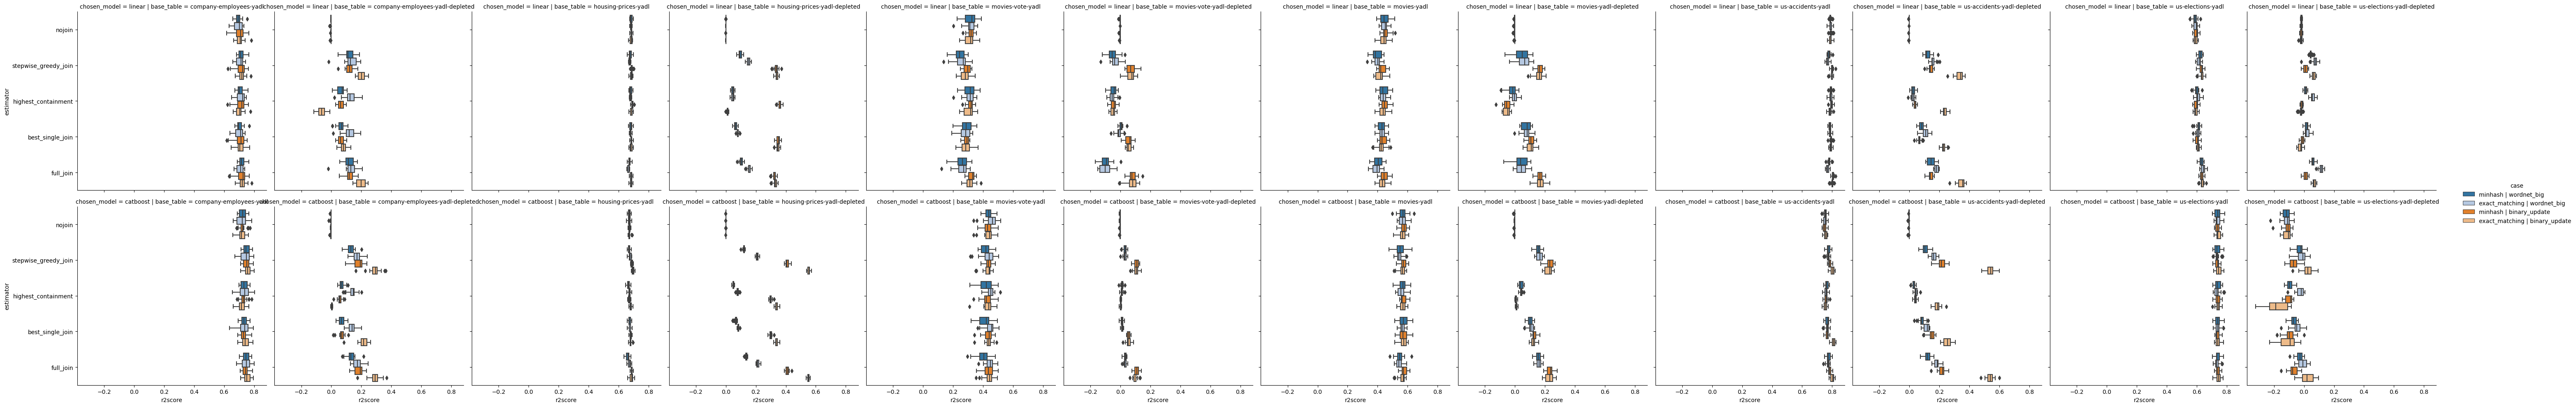

In [8]:
ax = sns.catplot(
    data=df_.to_pandas(),
    # data=df_.filter(pl.col("chosen_model") == "catboost").to_pandas(),
    x="r2score",
    y="estimator",
    hue="case",
    kind="box",
    col="base_table",
    row="chosen_model",
    sharex=True,
    # col_wrap=2,
    col_order=col_order,
    # facet_kws={"xlim": [0,1]}
    palette="tab20",
)

# Open Data

In [10]:
run_path = (
    "/home/soda/rcappuzz/work/benchmark-join-suggestions/results/logs/0313-i4ler0yd"
)

In [11]:
df_raw = read_logs(exp_name=None, exp_path=run_path)
df_raw = df_raw.with_columns(pl.col("epsilon").cast(pl.Utf8))

In [12]:
df_ = df_raw.select(
    pl.col(
        [
            "scenario_id",
            "target_dl",
            "jd_method",
            "base_table",
            "estimator",
            "chosen_model",
            "aggregation",
            "r2score",
            "time_fit",
            "time_predict",
            "time_run",
            "epsilon",
        ]
    )
)

In [13]:
col_order = (
    df_.select(pl.col("base_table")).unique().sort("base_table").to_series().to_list()
)

In [14]:
df_ = df_.with_columns(
    (pl.col("jd_method") + " | " + pl.col("target_dl")).alias("case")
)

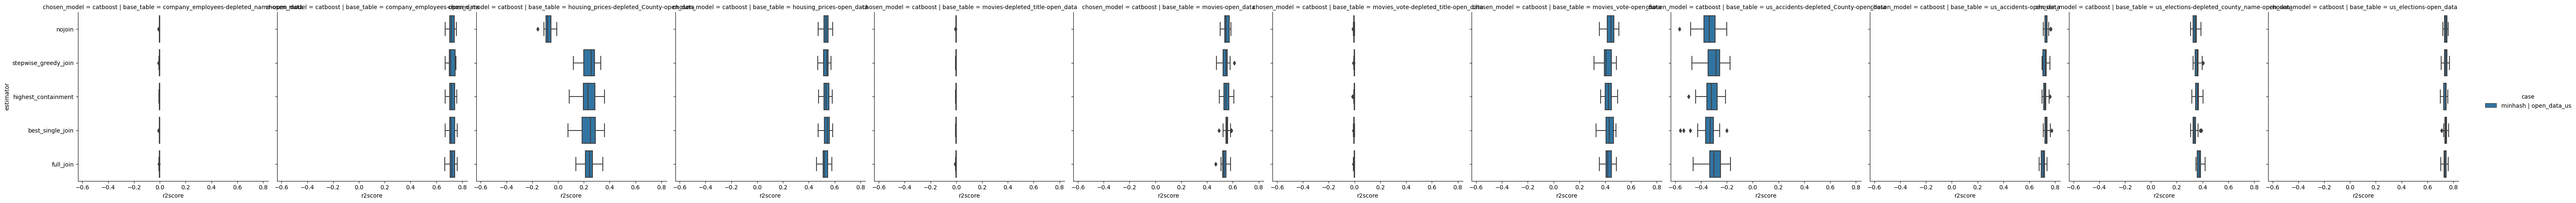

In [15]:
ax = sns.catplot(
    data=df_.to_pandas(),
    # data=df_.filter(pl.col("chosen_model") == "catboost").to_pandas(),
    x="r2score",
    y="estimator",
    hue="case",
    kind="box",
    col="base_table",
    row="chosen_model",
    sharex=True,
    # col_wrap=2,
    col_order=col_order,
    # facet_kws={"xlim": [0,1]}
    palette="tab20",
)

# Combine the runs

In [43]:
runs_to_study = [
    "0309-imi1u8db",
    "0313-i4ler0yd",
    "0312-a7q8676p",
]

list_df = []

for run_name in runs_to_study:
    df_t = read_logs(exp_name=run_name)
    list_df.append(df_t)

df_combined = pl.concat(list_df)

In [44]:
df_ = df_combined.select(
    pl.col(
        [
            "scenario_id",
            "target_dl",
            "jd_method",
            "base_table",
            "estimator",
            "chosen_model",
            "aggregation",
            "r2score",
            "time_fit",
            "time_predict",
            "time_run",
            "epsilon",
        ]
    )
)
df_ = df_.with_columns(
    pl.col("base_table")
    .str.replace("-yadl", "")
    .str.replace("-open_data", "")
    .str.replace("_", "-")
)

In [45]:
col_order = (
    df_.select(pl.col("base_table")).unique().sort("base_table").to_series().to_list()
)

In [46]:
df_ = df_.with_columns(
    (pl.col("jd_method") + " | " + pl.col("target_dl")).alias("case")
)

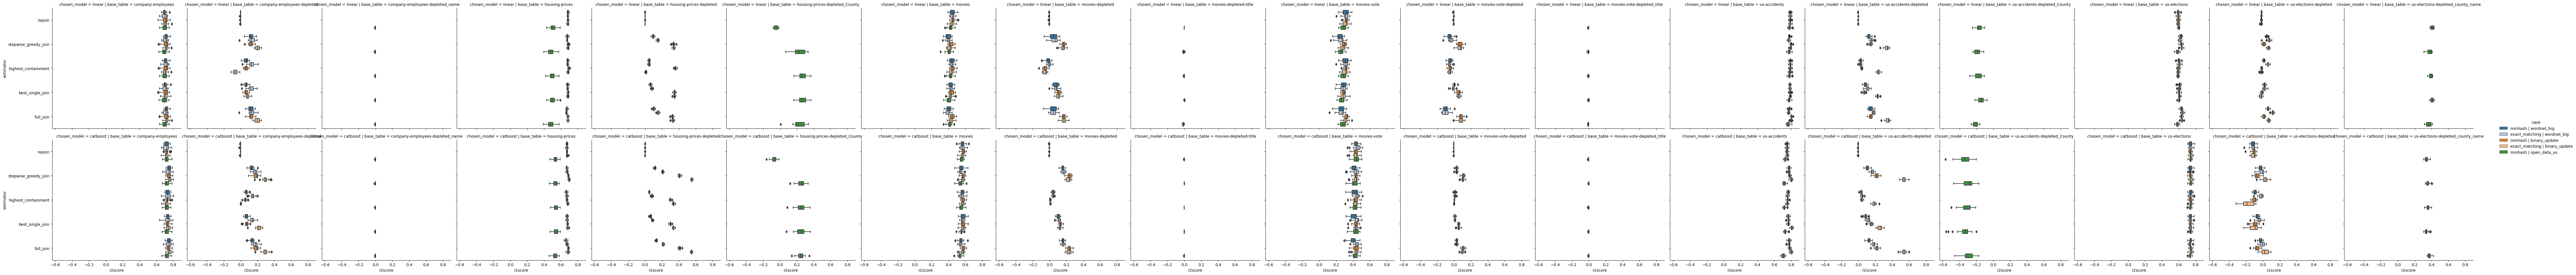

In [47]:
ax = sns.catplot(
    data=df_.to_pandas(),
    # data=df_.filter(pl.col("chosen_model") == "catboost").to_pandas(),
    x="r2score",
    y="estimator",
    hue="case",
    kind="box",
    col="base_table",
    row="chosen_model",
    sharex=True,
    # col_wrap=2,
    col_order=col_order,
    # facet_kws={"xlim": [0,1]}
    palette="tab20",
)

In [ ]:
for table in df_["base_table"].unique():
    ax=sns.catplot(
        data=df_.filter(pl.col("base_table") == table).to_pandas(),
        y="r2score",
        x="estimator",
        hue="case",
        kind="box",
        # col="base_table",
        col="chosen_model",
        # sharex=True,
        # col_wrap=2,
        # col_order=col_order,
        # facet_kws={"xlim": [0,1]}
        palette="tab20",
    )
    ax.set_xticklabels(rotation=30)
    ax.fig.subplots_adjust(top=0.9)

    ax.fig.suptitle(table)
